In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [2]:
df_preprocessed = pd.read_csv('data/processed/bookings_PreProcessed.csv')
df_preprocessed.head()

,duration_log,hour_sin,hour_cos,dow_0,dow_1,dow_2,dow_3,dow_4,month_1,month_2,...,task_TASK-010,task_TASK-011,task_TASK-012,task_TASK-013,task_TASK-014,task_TASK-015,task_TASK-016,task_TASK-017,task_TASK-018,task_TASK-019
0,3.637586,0.707107,-0.707107,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4.110874,0.707107,-0.707107,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.060443,0.707107,-0.707107,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3.988984,0.707107,-0.707107,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4.488636,0.500000,-0.866025,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


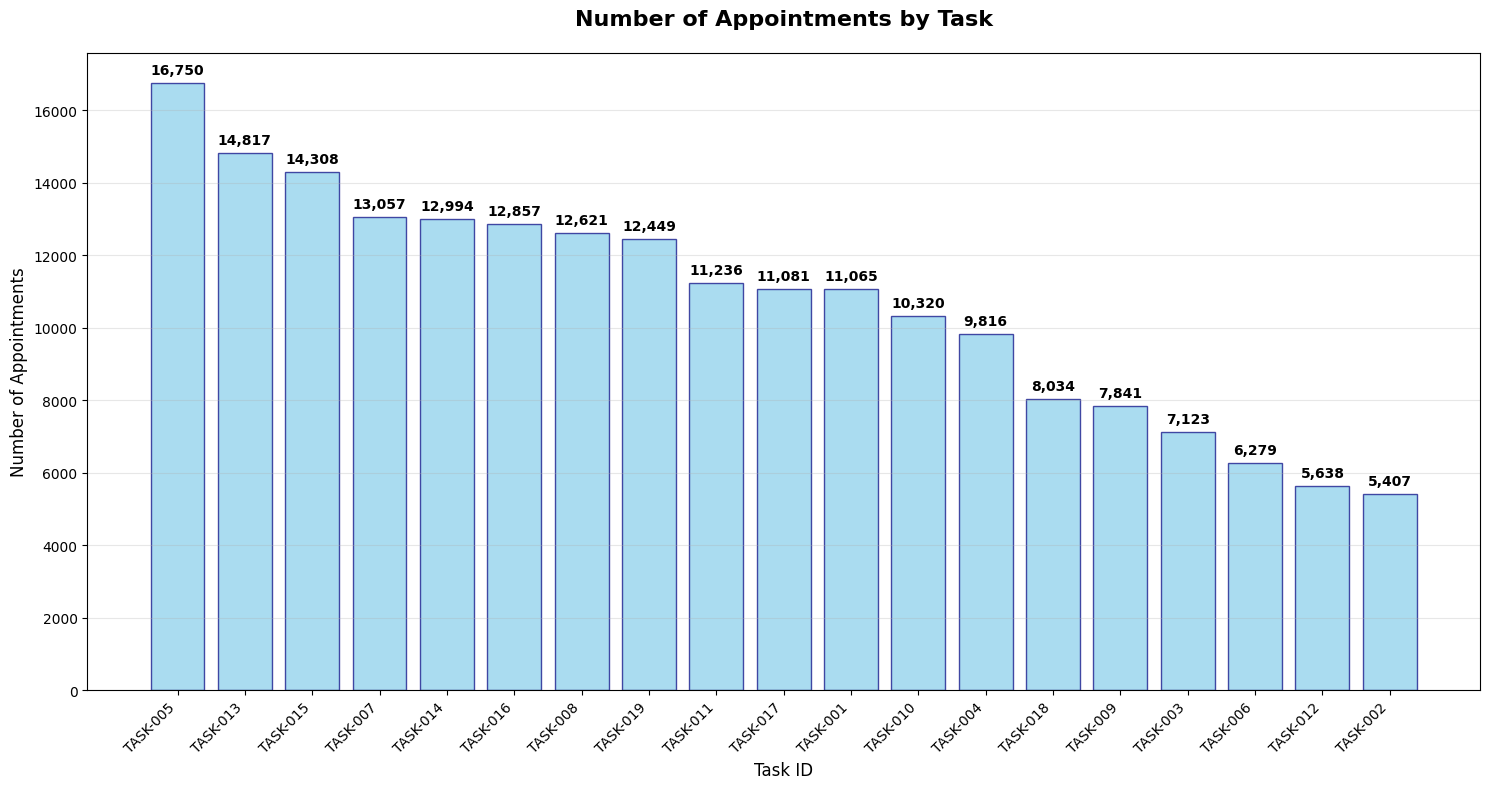


Summary Statistics:
Total number of appointments: 203,693
Number of tasks: 19
Average appointments per task: 10,720.7
Most popular task: TASK-005 with 16,750 appointments
Least popular task: TASK-002 with 5,407 appointments


In [3]:
# Get task columns (columns starting with task_)
task_cols = [c for c in df_preprocessed.columns if c.startswith('task_')]

# Count appointments for each task
task_counts = df_preprocessed[task_cols].sum().sort_values(ascending=False)

# Create task names (remove 'task_' prefix)
task_names = [col.replace('task_', '') for col in task_counts.index]

# Create the visualization
plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(task_counts)), task_counts.values, color='skyblue', edgecolor='navy', alpha=0.7)

# Customize the plot
plt.title('Number of Appointments by Task', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Task ID', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)

# Set x-axis labels
plt.xticks(range(len(task_counts)), task_names, rotation=45, ha='right')

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, task_counts.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(task_counts.values)*0.01, 
             f'{int(count):,}', ha='center', va='bottom', fontweight='bold')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Total number of appointments: {task_counts.sum():,}")
print(f"Number of tasks: {len(task_counts)}")
print(f"Average appointments per task: {task_counts.mean():,.1f}")
print(f"Most popular task: {task_names[0]} with {task_counts.iloc[0]:,} appointments")
print(f"Least popular task: {task_names[-1]} with {task_counts.iloc[-1]:,} appointments")

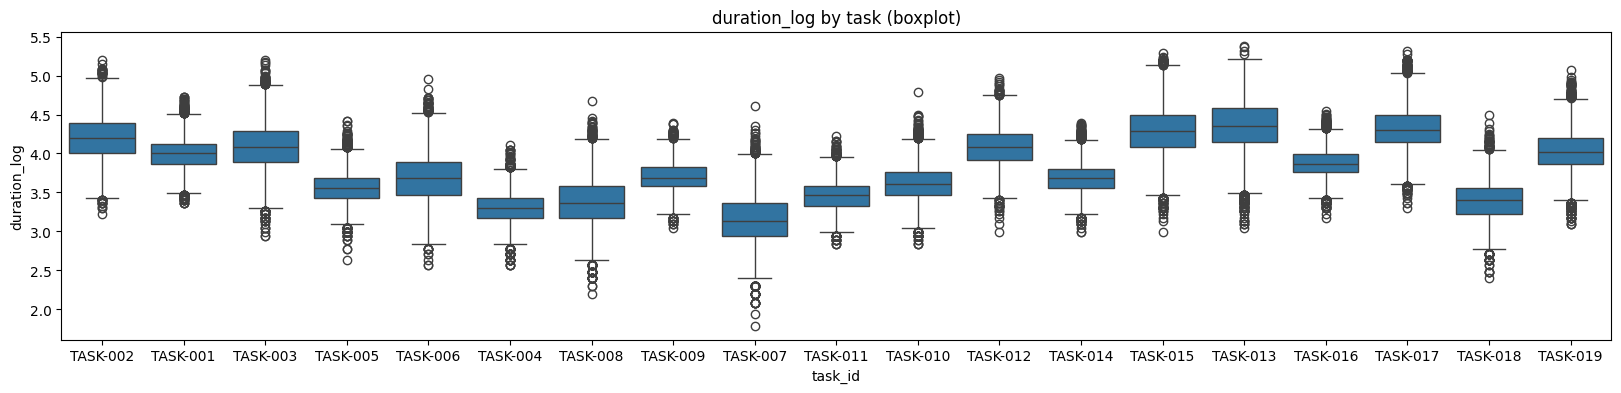

In [4]:
# create task_id column
df_preprocessed['task_id'] = df_preprocessed[task_cols].idxmax(axis=1).str.replace('task_', '')

# Visualize duration_log by task for TASK-010 vs TASK-011
subset = df_preprocessed.copy()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
sns.boxplot(data=subset, x='task_id', y='duration_log')
plt.title('duration_log by task (boxplot)')
plt.show()

In [5]:
# Split original dataset into train/test (stratified by task_id)
train_df, test_df = train_test_split(
    df_preprocessed,
    test_size=0.2,
    random_state=42,
    stratify=df_preprocessed['task_id']
)

# Sanity check: distributions should match closely
print("Train task dist (top):")
print(train_df['task_id'].value_counts(normalize=True).head())
print("\nTest task dist (top):")
print(test_df['task_id'].value_counts(normalize=True).head())

print("======================================================================")

print(f"Original train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train task dist (top):
task_id
TASK-005    0.082232
TASK-013    0.072738
TASK-015    0.070241
TASK-007    0.064104
TASK-014    0.063791
Name: proportion, dtype: float64

Test task dist (top):
task_id
TASK-005    0.082231
TASK-013    0.072756
TASK-015    0.070252
TASK-007    0.064091
TASK-014    0.063796
Name: proportion, dtype: float64
Original train shape: (162954, 46)
Test shape: (40739, 46)


In [6]:
# Compute winsorization caps from TRAIN ONLY
q_low, q_high = train_df['duration_log'].quantile([0.05, 0.95])

# Apply caps to train/test (test uses train caps to avoid leakage)
train_df['duration_log_wins'] = train_df['duration_log'].clip(lower=q_low, upper=q_high)
test_df['duration_log_wins'] = test_df['duration_log'].clip(lower=q_low, upper=q_high)

q_low, q_high

(3.091042453358316, 4.564348191467836)

In [7]:
# Balance only the train dataset
train_task_distribution = train_df['task_id'].value_counts()
print("\nTrain task distribution before balancing:")
print(train_task_distribution)
print(f"Imbalance ratio: {train_task_distribution.max() / train_task_distribution.min():.2f}")

# Determine target sample size for train
target_samples_per_task = int(train_task_distribution.median())
print(f"\nTarget samples per task in train: {target_samples_per_task}")

# Create balanced train dataset
balanced_train_data = []

for task in train_task_distribution.index:
    task_data = train_df[train_df['task_id'] == task]
    
    if len(task_data) > target_samples_per_task:
        # Downsample majority classes
        balanced_train_data.append(task_data.sample(n=target_samples_per_task, random_state=42))
    else:
        # Keep minority classes as is
        balanced_train_data.append(task_data)

train_df_balanced = pd.concat(balanced_train_data, ignore_index=True)

# Verify the balanced train distribution
balanced_train_counts = train_df_balanced['task_id'].value_counts()
print("\nBalanced train task distribution:")
print(balanced_train_counts)
print(f"New imbalance ratio: {balanced_train_counts.max() / balanced_train_counts.min():.2f}")

print(f"\nBalanced train shape: {train_df_balanced.shape}")
print(f"Test shape (unchanged): {test_df.shape}")


Train task distribution before balancing:
task_id
TASK-005    13400
TASK-013    11853
TASK-015    11446
TASK-007    10446
TASK-014    10395
TASK-016    10286
TASK-008    10097
TASK-019     9959
TASK-011     8989
TASK-017     8865
TASK-001     8852
TASK-010     8256
TASK-004     7853
TASK-018     6427
TASK-009     6273
TASK-003     5698
TASK-006     5023
TASK-012     4510
TASK-002     4326
Name: count, dtype: int64
Imbalance ratio: 3.10

Target samples per task in train: 8865

Balanced train task distribution:
task_id
TASK-005    8865
TASK-008    8865
TASK-013    8865
TASK-011    8865
TASK-019    8865
TASK-017    8865
TASK-016    8865
TASK-014    8865
TASK-007    8865
TASK-015    8865
TASK-001    8852
TASK-010    8256
TASK-004    7853
TASK-018    6427
TASK-009    6273
TASK-003    5698
TASK-006    5023
TASK-012    4510
TASK-002    4326
Name: count, dtype: int64
New imbalance ratio: 2.05

Balanced train shape: (145868, 47)
Test shape (unchanged): (40739, 47)


In [8]:
df_preprocessed.head()

,duration_log,hour_sin,hour_cos,dow_0,dow_1,dow_2,dow_3,dow_4,month_1,month_2,...,task_TASK-011,task_TASK-012,task_TASK-013,task_TASK-014,task_TASK-015,task_TASK-016,task_TASK-017,task_TASK-018,task_TASK-019,task_id
0,3.637586,0.707107,-0.707107,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,TASK-002
1,4.110874,0.707107,-0.707107,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,TASK-001
2,4.060443,0.707107,-0.707107,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,TASK-002
3,3.988984,0.707107,-0.707107,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,TASK-001
4,4.488636,0.500000,-0.866025,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,TASK-002


In [9]:
train_df.head()

,duration_log,hour_sin,hour_cos,dow_0,dow_1,dow_2,dow_3,dow_4,month_1,month_2,...,task_TASK-012,task_TASK-013,task_TASK-014,task_TASK-015,task_TASK-016,task_TASK-017,task_TASK-018,task_TASK-019,task_id,duration_log_wins
14562,3.367296,2.588190e-01,-0.965926,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,TASK-018,3.367296
60626,3.637586,5.000000e-01,-0.866025,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TASK-006,3.637586
170659,3.091042,-7.071068e-01,-0.707107,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,TASK-007,3.091042
157633,3.663562,7.071068e-01,-0.707107,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,TASK-012,3.663562
57868,3.610918,1.224647e-16,-1.000000,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,TASK-005,3.610918


In [10]:
# Prepare data for modeling
feature_cols = [c for c in df_preprocessed.columns if c not in ['duration_log', 'duration_log_wins', 'task_id']]

X_train = train_df_balanced[feature_cols].copy()
y_train = train_df_balanced['duration_log_wins'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['duration_log_wins'].copy()

X_train.shape, X_test.shape

((145868, 44), (40739, 44))

In [11]:
X_train.head()

,hour_sin,hour_cos,dow_0,dow_1,dow_2,dow_3,dow_4,month_1,month_2,month_3,...,task_TASK-010,task_TASK-011,task_TASK-012,task_TASK-013,task_TASK-014,task_TASK-015,task_TASK-016,task_TASK-017,task_TASK-018,task_TASK-019
0,-0.258819,-0.965926,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.707107,-0.707107,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.258819,-0.965926,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.500000,-0.866025,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.707107,-0.707107,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X_train1= X_train.head()
y_train1=y_train.head()
X_test1=X_test.head()
y_test1=y_test.head()

X_train1.to_csv('data/processed/bookings_X_train.csv', index=False)
y_train1.to_csv('data/processed/bookings_y_train.csv', index=False)
X_test1.to_csv('data/processed/bookings_X_test.csv', index=False)
y_test1.to_csv('data/processed/bookings_y_test.csv', index=False)

In [13]:
np.savez('artifacts/X_train.npz', X_train)
np.savez('artifacts/Y_train.npz', y_train)
np.savez('artifacts/X_test.npz', X_test)
np.savez('artifacts/Y_test.npz', y_test)